In [1]:
import numpy as np
import pickle

def transform_input(data, size=78):
    epochs = data['StimulusCode'].shape[0]
    electrodes = data['Signal'].shape[2]
    types = np.unique(data['StimulusCode'][0]).shape[0]-1 #without zeros
    
    STEP = 21 #12(flash) + 9(blank) - after preprocessing
    
    transformed_data = [[[] for _ in range(types)] for _ in range(epochs)]
    
    for epoch in range(epochs):
        signal = data['Signal'][epoch]
        
        #subsampling
        signal = np.delete(signal, range(1, signal.shape[0], 2), axis=0)
        stimulus_code = np.delete(data['StimulusCode'][epoch], range(1, data['StimulusCode'].shape[1], 2))
        
        for num in range(0, stimulus_code.shape[0]-size, STEP):
            id = int(stimulus_code[num])
            if id != 0:
                
                #normalization
                res_input = (signal[num:num+size] - np.mean(signal[num:num+size], axis=0))/\
                    np.std(signal[num:num+size], axis=0)
                
                transformed_data[epoch][id-1].append(res_input.T)
                
    return transformed_data

def transform_labels(data):
    epochs = data['StimulusCode'].shape[0]
    types = np.unique(data['StimulusCode'][0]).shape[0]-1
    
    labels = np.zeros((epochs, types))
    
    for epoch in range(epochs):
        stimulus_type = data['StimulusType'][epoch]
        stimulus_code = data['StimulusCode'][epoch]
        
        for id in range(types):
            labels[epoch, id] = stimulus_type[stimulus_code == id+1][0]
        
    return labels

def transform_test_labels(symbols):
    letters = [chr(x) for x in range(ord('A'), ord('Z')+1)]
    digits = [str(x) for x in range(1, 10)]
    keys = letters + digits + ['_']
    mapping = {keys[k]: (6+k//6, k%6) for k in range(len(keys))}

    output = np.zeros((len(symbols), 12))
    for num, symb in enumerate(symbols):
        pos = mapping[symb]
        output[num, pos[0]], output[num, pos[1]] = 1, 1
    
    return output

def final_transform(labels, inputs, filename=None):
    nb_samples = len(inputs) * len(inputs[0]) * len(inputs[0][0])
    X = np.zeros((nb_samples, 1, 64, 78))
    Y = np.zeros(nb_samples)
    n_sample = 0

    for epoch_num, epoch  in enumerate(inputs):
        for id, type_ in enumerate(epoch):
            for sample in type_:
                X[n_sample, 0] = sample
                Y[n_sample] = labels[epoch_num, id]
                n_sample += 1
    
    if type(filename) == str:
        with open('features_{}.pkl'.format(filename), 'wb') as f:
            pickle.dump(X, f)

        with open('labels_{}.pkl'.format(filename), 'wb') as f:
            pickle.dump(Y, f)
    


In [2]:
import scipy.io

file = scipy.io.loadmat('Subject_B_Train.mat')
labels = transform_labels(file)
inputs = transform_input(file)

final_transform(labels, inputs, filename='train_B')

In [3]:
import scipy.io
test_a_symbols = list("WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU")
test_b_symbols = list("MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR")

file = scipy.io.loadmat('Subject_B_Test.mat')
inputs = transform_input(file)
labels = transform_test_labels(test_b_symbols)

final_transform(labels, inputs, filename='test_B')

MemoryError: 

In [1]:
import pickle

def load_from_disk(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

X_train = load_from_disk('features_train_A.pkl')
Y_train = load_from_disk('labels_train_A.pkl')
X_test = load_from_disk('features_test_A.pkl')
Y_test = load_from_disk('labels_test_A.pkl')

In [2]:
import numpy as np
TRAIN_TEST_SPLIT = int(0.8 * X_train.shape[0])
X_train, X_validation = X_train[:TRAIN_TEST_SPLIT], X_train[TRAIN_TEST_SPLIT:]
Y_train, Y_validation = Y_train[:TRAIN_TEST_SPLIT], Y_train[TRAIN_TEST_SPLIT:]

In [3]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import SGD, Adam, Adadelta, RMSprop, Adagrad

Using Theano backend.


In [3]:
from keras.regularizers import l2

model = Sequential()
model.add(Convolution2D(10, 1, 64, input_shape=(1, 64, 78), activation='tanh', init='normal'))
model.add(Convolution2D(5, 13, 1, subsample=(13, 1), activation='tanh', init='normal'))
model.add(Flatten())
model.add(Dense(100, activation='sigmoid', init='normal'))
model.add(Dense(1, activation='sigmoid', init='normal'))


sgd = RMSprop()
model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])
val_loss = []

Using Theano backend.


In [11]:
from sklearn.metrics import recall_score, precision_score, f1_score
from keras.callbacks import Callback, EarlyStopping

class Logging(Callback):
    def on_epoch_end(self, epoch, logs={}):
        
        Y_pred = model.predict_classes(X_validation)
        val_loss.append(logs['val_loss'])
        print(recall_score(Y_validation, Y_pred))
        print(precision_score(Y_validation, Y_pred))
        print(f1_score(Y_validation, Y_pred))

metrics_logging = Logging()
model.fit(X_train, Y_train, batch_size=64, nb_epoch=100, 
          validation_data=(X_validation, Y_validation), class_weight={0: 0.16, 1: 0.84}, 
          callbacks=[metrics_logging]) #, EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='auto')])

Train on 12240 samples, validate on 3060 samples
Epoch 1/100
3060/3060 [==============================] - 3s     
0.725490196078
0.326566637246
0.450395617772
12240/12240 [==============================] - 36s - loss: 0.0506 - acc: 0.7182 - val_loss: 0.1906 - val_acc: 0.7049
Epoch 2/100
3060/3060 [==============================] - 4s     
0.719607843137
0.327386262266
0.450030656039
12240/12240 [==============================] - 41s - loss: 0.0504 - acc: 0.7144 - val_loss: 0.1896 - val_acc: 0.7069
Epoch 3/100
3060/3060 [==============================] - 4s     
0.725490196078
0.322580645161
0.446590223295
12240/12240 [==============================] - 40s - loss: 0.0503 - acc: 0.7149 - val_loss: 0.1924 - val_acc: 0.7003
Epoch 4/100
3060/3060 [==============================] - 3s     
0.73137254902
0.32017167382
0.445373134328
12240/12240 [==============================] - 36s - loss: 0.0502 - acc: 0.7154 - val_loss: 0.1952 - val_acc: 0.6964
Epoch 5/100
3060/3060 [======================

KeyboardInterrupt: 

In [206]:
model.save_weights('model_adagrad_mse.txt')

<IPython.core.display.Javascript object>


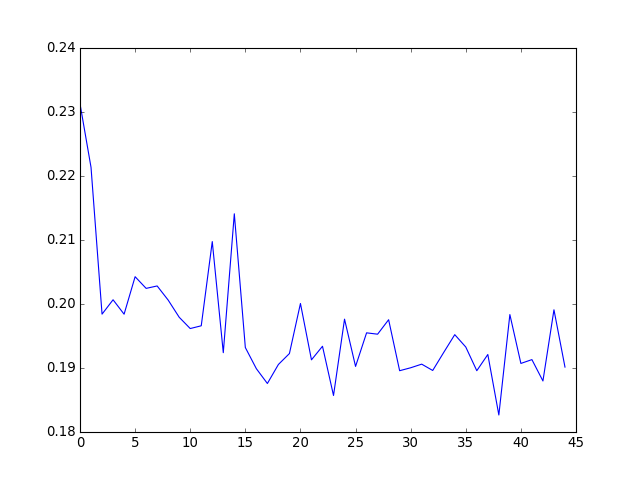

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.plot(val_loss)
plt.show()

In [14]:
model.evaluate(X_test, Y_test)

18000/18000 [==============================] - 23s    


[0.20489680846532185, 0.68366666666666664]

In [13]:
Y_pred = model.predict_classes(X_test)
print(recall_score(Y_test, Y_pred))
print(precision_score(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

18000/18000 [==============================] - 22s    
0.626
0.291162790698
0.39746031746
